# Feature Engineering of PUBG data with Model Developement
I previously created a notebook going through some [exploratory anaylsys] of the PUBG data. I went through many of the different features avalailable and displayed an interesting plot describing the data and potential correlation with the target variable.

I found that there was one missing value for the target variable and decided that this row of data should be removed, as there was only one player for the match identified by the missing value.

I also made a few decisions about creating new features and one important way of breaking the data up to gain higher correllations with our features for seperate match types.

---

## Import libraries
We import the required libraries and import the data

[exploratory anaylsys]:(https://www.kaggle.com/beaubellamy/pubg-eda#)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [70]:
train = pd.read_csv('train_V2.csv')
test = pd.read_csv('test_V2.csv')

Lets check out the data again, but before we do, lets down sample the data, becasue there are almost 4.5M rows.

In [71]:
#train = train[:2000000]
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [72]:
test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,...,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,...,1503,2,4669.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,...,1565,0,0.0,0,0.0,0,0,787.8,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,...,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,...,1480,1,0.0,0,0.0,0,0,2963.0,4,0


## Missing Data
Based on our EDA, we found a row that had a NULL value for the target variable. We will remove the irrelevant row of data.



In [73]:
# Remove the row with the missing target value
train = train[train['winPlacePerc'].isna() != True]

## Lets Engineer some features
We'll process the testing data the same way we do for the training data so the testing data has the same features and scaling as our training data.

### PlayersJoined
We can determine the number of players that joined each match by grouping the data by matchID and counting the players.

In [74]:
# Add a feature containing the number of players that joined each match.
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')
test['playersJoined'] = test.groupby('matchId')['matchId'].transform('count')

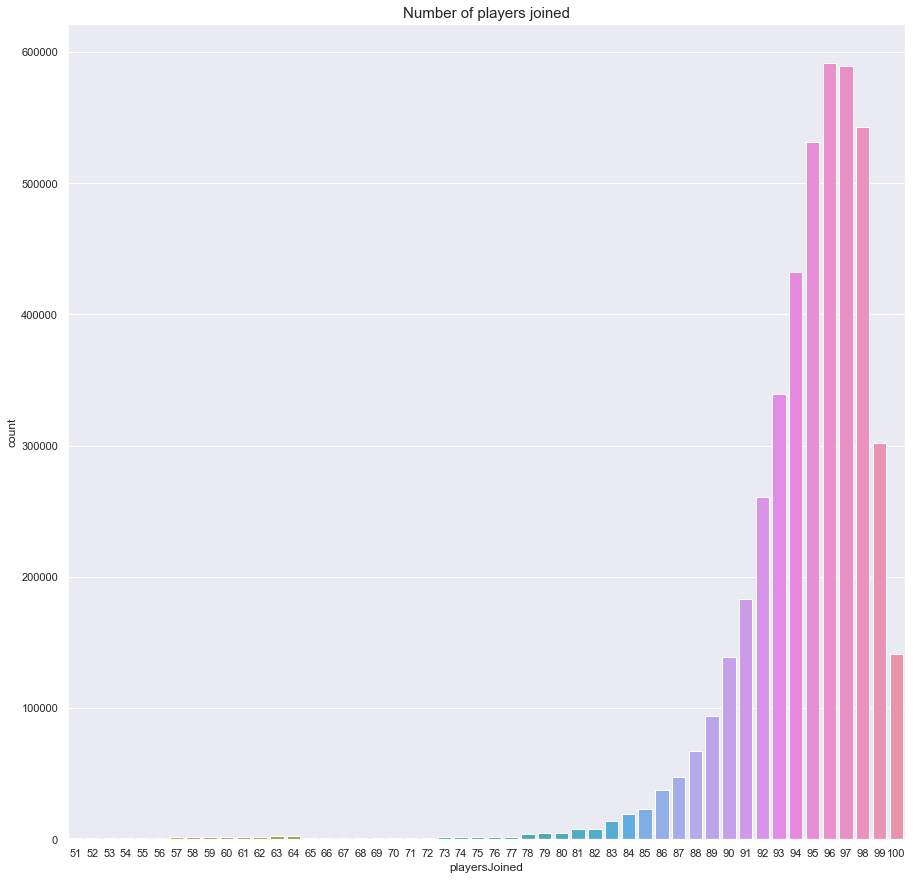

In [113]:
# Lets look at only those matches with more than 50 players.
data = train[train['playersJoined'] > 50]

plt.figure(figsize=(15,15))
sns.countplot(data['playersJoined'].sort_values())
plt.title('Number of players joined',fontsize=15)
plt.show()

You can see that there isn't always 100 players in each match, in fact its more likely to have between 90 and 100 players. It may be benficial to normalise those features that are affected by the number of players.

---

### Normalised Features
Here, I am making the assumption that it is easier to find an enemy when there are 100 players, than it is when there are 90 players.

In [75]:
def normaliseFeatures(df):
    df['killsNorm'] = df['kills']*((100-df['playersJoined'])/100 + 1)
    df['headshotKillsNorm'] = df['headshotKills']*((100-df['playersJoined'])/100 + 1)
    df['killPlaceNorm'] = df['killPlace']*((100-df['playersJoined'])/100 + 1)
    df['killPointsNorm'] = df['killPoints']*((100-df['playersJoined'])/100 + 1)
    df['killStreaksNorm'] = df['killStreaks']*((100-df['playersJoined'])/100 + 1)
    df['longestKillNorm'] = df['longestKill']*((100-df['playersJoined'])/100 + 1)
    df['roadKillsNorm'] = df['roadKills']*((100-df['playersJoined'])/100 + 1)
    df['teamKillsNorm'] = df['teamKills']*((100-df['playersJoined'])/100 + 1)
    df['damageDealtNorm'] = df['damageDealt']*((100-df['playersJoined'])/100 + 1)
    df['DBNOsNorm'] = df['DBNOs']*((100-df['playersJoined'])/100 + 1)
    df['revivesNorm'] = df['revives']*((100-df['playersJoined'])/100 + 1)

    # Remove the original features we normalised
    df = df.drop(['kills', 'headshotKills', 'killPlace', 'killPoints', 'killStreaks', 
                        'longestKill', 'roadKills', 'teamKills', 'damageDealt', 'DBNOs', 'revives'],axis=1)

    return df

In [76]:
train = normaliseFeatures(train)
test = normaliseFeatures(test)

In [77]:
train.head()


,Id,groupId,matchId,assists,boosts,heals,matchDuration,matchType,maxPlace,numGroups,...,headshotKillsNorm,killPlaceNorm,killPointsNorm,killStreaksNorm,longestKillNorm,roadKillsNorm,teamKillsNorm,damageDealtNorm,DBNOsNorm,revivesNorm
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0,1306,squad-fpp,28,26,...,0.0,62.40,1290.64,0.00,0.0000,0.0,0.0,0.0000,0.0,0.0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,0,1777,squad-fpp,26,25,...,0.0,62.13,0.00,0.00,0.0000,0.0,0.0,99.7023,0.0,0.0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,0,1318,duo,50,47,...,0.0,47.94,0.00,0.00,0.0000,0.0,0.0,69.3600,0.0,0.0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,0,1436,squad-fpp,31,30,...,0.0,81.75,0.00,0.00,0.0000,0.0,0.0,35.8610,0.0,0.0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,0,1424,solo-fpp,97,95,...,0.0,46.35,0.00,1.03,60.2859,0.0,0.0,103.0000,0.0,0.0


### TotalDistance
An additional feature we can create is the total distance the player travels. This is a combination of all the distance features in the original data set.

In [78]:
# Total distance travelled
train['totalDistance'] = train['walkDistance'] + train['rideDistance'] + train['swimDistance']
test['totalDistance'] = test['walkDistance'] + test['rideDistance'] + test['swimDistance']

### Features in relation to others
After some additional searching of other kernels, i found some features that i thought were a good approach, so i have blatenlty stolen Hyun Woo Kim's approach to feature engineering.

In [79]:
# Blatently stolen from Hyun Woo Kim https://www.kaggle.com/chocozzz/lightgbm-baseline

def createFeatureRates(data):
    data['headshotrate'] = data['killsNorm']/data['headshotKillsNorm']
    data['killStreakrate'] = data['killStreaksNorm']/data['killsNorm']
    data['healthitems'] = data['heals'] + data['boosts']
    data['killPlace_over_maxPlace'] = data['killPlaceNorm'] / data['maxPlace']
    data['headshotKills_over_kills'] = data['headshotKillsNorm'] / data['killsNorm']
    data['walkDistance_over_weapons'] = data['walkDistance'] / data['weaponsAcquired']
    data['walkDistance_over_heals'] = data['walkDistance'] / data['heals']
    data['walkDistance_over_kills'] = data['walkDistance'] / data['killsNorm']
    data['distance_over_weapons'] = data['totalDistance'] / data['weaponsAcquired']
    data['distance_over_heals'] = data['totalDistance'] / data['heals']
    data['distance_over_kills'] = data['totalDistance'] / data['killsNorm']
    data['killsPerDistance'] = data['killsNorm'] / data['totalDistance']
    data['skill'] = data['headshotKillsNorm'] + data['roadKillsNorm']
    
    data[data == np.Inf] = np.NaN
    data[data == np.NINF] = np.NaN
    
    data.fillna(0, inplace=True)
    
    return data


In [80]:
train = createFeatureRates(train)
test = createFeatureRates(test)

In [81]:
train.head()

,Id,groupId,matchId,assists,boosts,heals,matchDuration,matchType,maxPlace,numGroups,...,killPlace_over_maxPlace,headshotKills_over_kills,walkDistance_over_weapons,walkDistance_over_heals,walkDistance_over_kills,distance_over_weapons,distance_over_heals,distance_over_kills,killsPerDistance,skill
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0,1306,squad-fpp,28,26,...,2.228571,0.0,244.800000,0.0,0.000000,244.800000,0.0,0.000000,0.000000,0.0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,0,1777,squad-fpp,26,25,...,2.389615,0.0,286.800000,0.0,0.000000,289.008900,0.0,0.000000,0.000000,0.0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,0,1318,duo,50,47,...,0.958800,0.0,80.900000,0.0,0.000000,80.900000,0.0,0.000000,0.000000,0.0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,0,1436,squad-fpp,31,30,...,2.637097,0.0,67.566667,0.0,0.000000,67.566667,0.0,0.000000,0.000000,0.0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,0,1424,solo-fpp,97,95,...,0.477835,0.0,24.875000,0.0,48.300971,24.875000,0.0,48.300971,0.020704,0.0


## Standardize the matchType feature
Here I decided that many of the existing 16 seperate modes of game play were just different versions of four types of game.

1. Solo: Hunger Games style, last man/women standing.
2. Duo: Teams of two against all other players.
3. Squad: Teams of up to 4 players against All other players
4. Other: These modes consist of custom and special events modes

In [82]:
# Normalise the matchTypes to standard fromat
def standardize_matchType(data):
    data['matchType'][data['matchType'] == 'normal-solo'] = 'Solo'
    data['matchType'][data['matchType'] == 'solo-fpp'] = 'Solo'
    data['matchType'][data['matchType'] == 'normal-solo-fpp'] = 'Solo'
    data['matchType'][data['matchType'] == 'normal-duo-fpp'] = 'Duo'
    data['matchType'][data['matchType'] == 'normal-duo'] = 'Duo'
    data['matchType'][data['matchType'] == 'duo-fpp'] = 'Duo'
    data['matchType'][data['matchType'] == 'squad-fpp'] = 'Squad'
    data['matchType'][data['matchType'] == 'normal-squad'] = 'Squad'
    data['matchType'][data['matchType'] == 'normal-squad-fpp'] = 'Squad'
    data['matchType'][data['matchType'] == 'flaretpp'] = 'Other'
    data['matchType'][data['matchType'] == 'flarefpp'] = 'Other'
    data['matchType'][data['matchType'] == 'crashtpp'] = 'Other'
    data['matchType'][data['matchType'] == 'crashfpp'] = 'Other'

    return data

In [83]:
train = standardize_matchType(train)
test = standardize_matchType(test)

In [84]:
# We need a copy of the test data with the player id later on
test_submission = test.copy()

train = train.drop(['Id','groupId','matchId'], axis=1)
test = test.drop(['Id','groupId','matchId'], axis=1)

In [85]:
# We need to keep a copy of the test data for the test id's later 
train_copy = train.copy()
test_copy = test.copy()

Now we can transform the matchTypes into dummy values so we can use them in the model.

In [86]:
# Transform the matchType into scalar values
le = LabelEncoder()
train['matchType']=le.fit_transform(train['matchType'])
test['matchType']=le.fit_transform(test['matchType'])

In [87]:
# We can do a sanity check of the data, making sure we have the new 
# features created and the matchType feature is standardised.
train.head()

,assists,boosts,heals,matchDuration,matchType,maxPlace,numGroups,rankPoints,rideDistance,swimDistance,...,killPlace_over_maxPlace,headshotKills_over_kills,walkDistance_over_weapons,walkDistance_over_heals,walkDistance_over_kills,distance_over_weapons,distance_over_heals,distance_over_kills,killsPerDistance,skill
0,0,0,0,1306,3,28,26,-1,0.0000,0.00,...,2.228571,0.0,244.800000,0.0,0.000000,244.800000,0.0,0.000000,0.000000,0.0
1,0,0,0,1777,3,26,25,1484,0.0045,11.04,...,2.389615,0.0,286.800000,0.0,0.000000,289.008900,0.0,0.000000,0.000000,0.0
2,1,0,0,1318,4,50,47,1491,0.0000,0.00,...,0.958800,0.0,80.900000,0.0,0.000000,80.900000,0.0,0.000000,0.000000,0.0
3,0,0,0,1436,3,31,30,1408,0.0000,0.00,...,2.637097,0.0,67.566667,0.0,0.000000,67.566667,0.0,0.000000,0.000000,0.0
4,0,0,0,1424,2,97,95,1560,0.0000,0.00,...,0.477835,0.0,24.875000,0.0,48.300971,24.875000,0.0,48.300971,0.020704,0.0


## Scale the features
Some features have very large values and a vary large variance. For any regresion analysis, it is good practice to scale all features to similar variance. This would not be neccessary if the variance of all features was between 6 and 10.

In [88]:
train.describe()

,assists,boosts,heals,matchDuration,matchType,maxPlace,numGroups,rankPoints,rideDistance,swimDistance,...,killPlace_over_maxPlace,headshotKills_over_kills,walkDistance_over_weapons,walkDistance_over_heals,walkDistance_over_kills,distance_over_weapons,distance_over_heals,distance_over_kills,killsPerDistance,skill
count,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,...,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06
mean,2.338150e-01,1.106908e+00,1.370148e+00,1.579507e+03,2.773191e+00,4.450468e+01,4.300760e+01,8.920103e+02,6.061158e+02,4.509323e+00,...,1.379862e+00,1.031199e-01,2.820571e+02,3.849458e+02,3.875498e+02,4.175495e+02,5.827473e+02,5.796717e+02,2.149679e-03,2.453505e-01
std,5.885731e-01,1.715794e+00,2.679982e+00,2.587388e+02,1.899852e+00,2.382810e+01,2.328949e+01,7.366478e+02,1.498344e+03,3.050220e+01,...,1.001008e+00,2.604399e-01,2.918436e+02,7.401846e+02,7.301447e+02,5.372608e+02,1.234095e+03,1.254303e+03,4.032943e-02,6.676683e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.330000e+02,0.000000e+00,2.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,1.367000e+03,2.000000e+00,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,...,5.691489e-01,0.000000e+00,6.730000e+01,0.000000e+00,0.000000e+00,6.813333e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,1.438000e+03,3.000000e+00,3.000000e+01,3.000000e+01,1.443000e+03,0.000000e+00,0.000000e+00,...,1.166667e+00,0.000000e+00,1.910000e+02,0.000000e+00,0.000000e+00,2.236500e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,2.000000e+00,2.000000e+00,1.851000e+03,4.000000e+00,4.900000e+01,4.700000e+01,1.500000e+03,1.910000e-01,0.000000e+00,...,2.012308e+00,0.000000e+00,4.138333e+02,4.552000e+02,4.807407e+02,5.868000e+02,6.306000e+02,5.771957e+02,9.819121e-04,0.000000e+00
max,2.200000e+01,3.300000e+01,8.000000e+01,2.237000e+03,6.000000e+00,1.000000e+02,1.000000e+02,5.910000e+03,4.071000e+04,3.823000e+03,...,4.939500e+01,1.000000e+00,1.366000e+04,1.513000e+04,1.355769e+04,3.260200e+04,3.194820e+04,3.104952e+04,7.256098e+01,9.792000e+01


You can see most features range 0 to 100 or 1000's, but there are two features that doesn't really need scaling, VehicleDestroys and matchType, as they only range between 0 to 5, 6. Its not neccassary to scale these features, but we will any way, because it makes the code easier.

In [89]:
scaler = MinMaxScaler()

train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
test_scaled = pd.DataFrame(scaler.fit_transform(test), columns=test.columns)

train_scaled.head()

,assists,boosts,heals,matchDuration,matchType,maxPlace,numGroups,rankPoints,rideDistance,swimDistance,...,killPlace_over_maxPlace,headshotKills_over_kills,walkDistance_over_weapons,walkDistance_over_heals,walkDistance_over_kills,distance_over_weapons,distance_over_heals,distance_over_kills,killsPerDistance,skill
0,0.000000,0.0,0.0,0.557510,0.500000,0.265306,0.252525,0.000000,0.000000e+00,0.000000,...,0.044924,0.0,0.017921,0.0,0.000000,0.007509,0.0,0.000000,0.000000,0.0
1,0.000000,0.0,0.0,0.781369,0.500000,0.244898,0.242424,0.251227,1.105380e-07,0.002888,...,0.048185,0.0,0.020996,0.0,0.000000,0.008865,0.0,0.000000,0.000000,0.0
2,0.045455,0.0,0.0,0.563213,0.666667,0.489796,0.464646,0.252411,0.000000e+00,0.000000,...,0.019212,0.0,0.005922,0.0,0.000000,0.002481,0.0,0.000000,0.000000,0.0
3,0.000000,0.0,0.0,0.619297,0.500000,0.295918,0.292929,0.238369,0.000000e+00,0.000000,...,0.053196,0.0,0.004946,0.0,0.000000,0.002072,0.0,0.000000,0.000000,0.0
4,0.000000,0.0,0.0,0.613593,0.333333,0.969388,0.949495,0.264084,0.000000e+00,0.000000,...,0.009473,0.0,0.001821,0.0,0.003563,0.000763,0.0,0.001556,0.000285,0.0


In [90]:
train_scaled.describe()

,assists,boosts,heals,matchDuration,matchType,maxPlace,numGroups,rankPoints,rideDistance,swimDistance,...,killPlace_over_maxPlace,headshotKills_over_kills,walkDistance_over_weapons,walkDistance_over_heals,walkDistance_over_kills,distance_over_weapons,distance_over_heals,distance_over_kills,killsPerDistance,skill
count,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,...,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06
mean,1.062795e-02,3.354267e-02,1.712684e-02,6.875032e-01,4.621985e-01,4.337212e-01,4.243192e-01,1.510760e-01,1.488862e-02,1.179525e-03,...,2.773842e-02,1.031199e-01,2.064840e-02,2.544255e-02,2.858524e-02,1.280748e-02,1.824038e-02,1.866926e-02,2.962582e-05,2.505622e-03
std,2.675332e-02,5.199375e-02,3.349978e-02,1.229747e-01,3.166420e-01,2.431439e-01,2.352474e-01,1.246232e-01,3.680530e-02,7.978604e-03,...,2.026947e-02,2.604399e-01,2.136483e-02,4.892165e-02,5.385464e-02,1.647938e-02,3.862799e-02,4.039684e-02,5.558005e-04,6.818508e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,5.865019e-01,3.333333e-01,2.653061e-01,2.626263e-01,0.000000e+00,0.000000e+00,0.000000e+00,...,1.132224e-02,0.000000e+00,4.926794e-03,0.000000e+00,0.000000e+00,2.089851e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,6.202471e-01,5.000000e-01,2.857143e-01,2.929293e-01,2.442903e-01,0.000000e+00,0.000000e+00,...,2.342142e-02,0.000000e+00,1.398243e-02,0.000000e+00,0.000000e+00,6.860009e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,6.060606e-02,2.500000e-02,8.165399e-01,6.666667e-01,4.795918e-01,4.646465e-01,2.539333e-01,4.691722e-06,0.000000e+00,...,4.054486e-02,0.000000e+00,3.029527e-02,3.008592e-02,3.545889e-02,1.799890e-02,1.973820e-02,1.858952e-02,1.353223e-05,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


As you can see, all the features have the same minimum, maximum and standard deviation. All our features are now normalised and scaled for modelling.

---

## Model Development
I have previously created a [kernel] to explore the data and develop some new features. From this exploratory analysis, I found that by breaking the data into four seperate matchtypes improved the accuracy of the models. The four main match types will be described by the following four groups;

1. Solo: Hunger Games style, last man/women standing.
2. Duo: Teams of two against all other players.
3. Squad: Teams of up to 4 players against All other players
4. Other: These modes consist of custom and special events modes

[kernel]:(https://www.kaggle.com/beaubellamy/pubg-eda#)

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

In [92]:
# Extract the target variable.
y = train_scaled['winPlacePerc']
X = train_scaled.drop(['winPlacePerc'],axis=1)

# Split the data in to training and validation set
size = 0.3
seed = 42
   
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=size, random_state=seed)

## Model Development for seperate matchTypes
Again, with the insight we learnt from our [EDA], we found that it is likely that we will improve our overall results by creating four seperate models, one for each matchType. This allows us to potentially use a seperate type of model for each matchType.

Here we'll split the data into the matchTypes and see how the models perform for each one.

[EDA]:(https://www.kaggle.com/beaubellamy/pubg-eda#)

In [93]:
# Create a data set for each matchType and drop that feature, as there will be no variance, and hence no predictive power.
solo = train_copy[train_copy['matchType'] == 'Solo']
solo = solo.drop(['matchType'], axis=1)
duo = train_copy[train_copy['matchType'] == 'Duo']
duo = duo.drop(['matchType'], axis=1)
squad = train_copy[train_copy['matchType'] == 'Squad']
squad = squad.drop(['matchType'], axis=1)
other = train_copy[train_copy['matchType'] == 'Other']
other = other.drop(['matchType'], axis=1)

# since we used a copy of the trained data that hasn't been scaled, we need to scale the features again.
scaler = MinMaxScaler()
solo_scaled = pd.DataFrame(scaler.fit_transform(solo), columns=solo.columns)
duo_scaled = pd.DataFrame(scaler.fit_transform(duo), columns=duo.columns)
squad_scaled = pd.DataFrame(scaler.fit_transform(squad), columns=squad.columns)
other_scaled = pd.DataFrame(scaler.fit_transform(other), columns=other.columns)

# Seperate the matchType data
test_solo = test_copy[test_copy['matchType'] == 'Solo']
test_solo = test_solo.drop(['matchType'], axis=1)
test_duo = test_copy[test_copy['matchType'] == 'Duo']
test_duo = test_duo.drop(['matchType'], axis=1)
test_squad = test_copy[test_copy['matchType'] == 'Squad']
test_squad = test_squad.drop(['matchType'], axis=1)
test_other = test_copy[test_copy['matchType'] == 'Other']
test_other = test_other.drop(['matchType'], axis=1)

solo_test_scaled = pd.DataFrame(scaler.fit_transform(test_solo), columns=test_solo.columns)
duo_test_scaled = pd.DataFrame(scaler.fit_transform(test_duo), columns=test_duo.columns)
squad_test_scaled = pd.DataFrame(scaler.fit_transform(test_squad), columns=test_squad.columns)
other_test_scaled = pd.DataFrame(scaler.fit_transform(test_other), columns=test_other.columns)

We'll train each of the sets of data separately.

In [94]:
solo_y = solo_scaled['winPlacePerc']
solo_X = solo_scaled.drop(['winPlacePerc'],axis=1)

# We will maintain the existing size and random state parameters for repeatability.
X_train, X_validation, Y_train, Y_validation = train_test_split(solo_X, solo_y, test_size=size, random_state=seed)

In [95]:
GBR = GradientBoostingRegressor(learning_rate=0.8)
GBR.fit(X_train,Y_train)
print("GradientBoost Model traininig: {0:.3f}%".format(GBR.score(X_validation,Y_validation)*100))

GradientBoost Model traininig: 96.041%


In [96]:
duo_y = duo_scaled['winPlacePerc']
duo_X = duo_scaled.drop(['winPlacePerc'],axis=1)

# We will maintain the existing size and random state parameters for repeatability.
X_train, X_validation, Y_train, Y_validation = train_test_split(duo_X, duo_y, test_size=size, random_state=seed)


In [97]:
GBR = GradientBoostingRegressor(learning_rate=0.8)
GBR.fit(X_train,Y_train)
print("GradientBoost Model traininig: {0:.3f}%".format(GBR.score(X_validation,Y_validation)*100))

predictions_duo = GBR.predict(duo_test_scaled) 

GradientBoost Model traininig: 94.688%


In [98]:
squad_y = squad_scaled['winPlacePerc']
squad_X = squad_scaled.drop(['winPlacePerc'],axis=1)

# We will maintain the existing size and random state parameters for repeatability.
X_train, X_validation, Y_train, Y_validation = train_test_split(squad_X, squad_y, test_size=size, random_state=seed)

In [99]:
GBR = GradientBoostingRegressor(learning_rate=0.8)
GBR.fit(X_train,Y_train)
print("GradientBoost Model traininig: {0:.3f}%".format(GBR.score(X_validation,Y_validation)*100))

GradientBoost Model traininig: 91.742%


In [100]:
other_y = other_scaled['winPlacePerc']
other_X = other_scaled.drop(['winPlacePerc'],axis=1)

# We will maintain the existing size and random state parameters for repeatability.
X_train, X_validation, Y_train, Y_validation = train_test_split(other_X, other_y, test_size=size, random_state=seed)

In [101]:
GBR = GradientBoostingRegressor(learning_rate=0.8)
GBR.fit(X_train,Y_train)
print("GradientBoost Model traininig: {0:.3f}%".format(GBR.score(X_validation,Y_validation)*100))

predictions_other = GBR.predict(other_test_scaled) 

GradientBoost Model traininig: 90.986%


Fitting 70% of the training data to a Gradient Boosting Regression we can achieve netween 91 - 94% accuracy on the remaining 30% of the data.

We've validated our model, so now we can fit all the data to each model to maximise the use of the data, then make some predictions on the fully trained model.

In [102]:
GBR_solo = GradientBoostingRegressor(learning_rate=0.8)
GBR_solo.fit(solo_X,solo_y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.8, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [103]:
GBR_duo = GradientBoostingRegressor(learning_rate=0.8)
GBR_duo.fit(duo_X,duo_y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.8, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [104]:
GBR_squad = GradientBoostingRegressor(learning_rate=0.8)
GBR_squad.fit(squad_X,squad_y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.8, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [105]:
GBR_other = GradientBoostingRegressor(learning_rate=0.8)
GBR_other.fit(other_X,other_y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.8, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [106]:
predictions_solo = GBR_solo.predict(solo_test_scaled)
predictions_duo = GBR_duo.predict(duo_test_scaled)
predictions_squad = GBR_squad.predict(squad_test_scaled)
predictions_other = GBR_other.predict(other_test_scaled)

In [107]:
test_submission_solo = test_submission[test_submission['matchType'] == 'Solo']
test_submission_duo = test_submission[test_submission['matchType'] == 'Duo']
test_submission_squad = test_submission[test_submission['matchType'] == 'Squad']
test_submission_other = test_submission[test_submission['matchType'] == 'Other']

# Aggregate the Id's together again
matchTypeId = test_submission_solo['Id'].append(test_submission_duo['Id']).append(test_submission_squad['Id']).append(test_submission_other['Id'])

predictions_solo[predictions_solo > 1] = 1
predictions_solo[predictions_solo < 0] = 0

predictions_duo[predictions_duo > 1] = 1
predictions_duo[predictions_duo < 0] = 0

predictions_squad[predictions_squad > 1] = 1
predictions_squad[predictions_squad < 0] = 0

predictions_other[predictions_other > 1] = 1
predictions_other[predictions_other < 0] = 0

# Aggregate the final predictions from each model. This must be the same order as the aggregation of the Id's
predictions_matchtype = np.append(np.append(predictions_solo,predictions_duo),np.append(predictions_squad,predictions_other))

In [108]:
submission = pd.DataFrame({'Id': matchTypeId, 'winPlacePerc': predictions_matchtype})
submission.to_csv('submission_matchType.csv',index=False)